In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from asyncio import sleep
import mne
from mne.preprocessing import ICA
from mne_icalabel import label_components
from networkx.readwrite.graph6 import n_to_data
from sympy import transpose

from shallow_nn_model_class import shallow_nn_models


In [3]:
df=pd.read_csv('BCI Tests - Foaie1.csv')
#Get df["Name"] as title
df["Nume"]=df["Nume"].apply(lambda x: x.title())
df.columns=df.columns.str.strip()
df

,Nume,Culoare,Raspuns Intrebari
0,David,2,3/5
1,Amalia,3,2/5
2,Robert,2,5/5
3,Darius,0,5/5
4,Andrei,3,5/5
5,Toni,1,3/5
6,Asalos,2,4/5
7,Bogdan,1,4/5
8,Toni 2,1,5/5
9,Darius 2,0,5/5


In [4]:
from Preprocces import  pipeline
def preprocessing(path):
    notched=[50, 100]
    ica=ICA(n_components=16,
            max_iter='auto',           
            method='fastica',
            random_state=42)
    Pipeline=pipeline(ica)
    raw=Pipeline.load_Data(path)
    print(raw)
    print(raw.info['ch_names'])
    raw.pick_channels(['P8', 'O2', 'P4', 'C4', 'F8', 'F4', 'Oz', 'Cz', 'Fz', 'Pz', 'F3', 'O1', 'P7', 'C3', 'P3', 'F7'])
    high_passed=raw.filter(l_freq=1.0, h_freq=None)
    high_passed=high_passed.filter(l_freq=None, h_freq=100.0)
    notched=high_passed.notch_filter(notched,
                                     picks='eeg',
                                     filter_length='auto',
                                     phase='zero',
                                     verbose=True)
    notched=notched.set_eeg_reference('average')
    ica=ICA(n_components=None,
            max_iter='auto',
            method='fastica',
            random_state=97)
    ica.fit(notched)
    raw.load_data()
    ic_labels=label_components(notched, ica, method='iclabel')
    print(ic_labels['labels'])
    labels=ic_labels['labels']
    exclude_idx=[idx for idx, label in enumerate(labels) if label not in ['brain']]
    print(f'Excluding these ICA components{exclude_idx}')
    reconst_raw=notched.copy()
    ica.apply(reconst_raw, exclude=exclude_idx) 
    #spectrumus=reconst_raw.compute_psd()
    #spectrumus.plot(exclude='bads', amplitude=False).savefig('plangus.png')
    return reconst_raw

In [5]:
import os
import mne
import numpy as np

def load_data_by_color(id, df):
    X = []
    y = []
    df = df[df["Culoare"] == id]
    path = './Recordings'
    
    for i in range(len(df)):
        nume = df.iloc[i]['Nume']
        path_to_file = os.path.join(path, nume)
        
        if os.path.exists(path_to_file):
            print(f'File {nume} loaded')
            files_in_folder = os.listdir(path_to_file)
            
            for file in files_in_folder:
                if 'Vid Attention' in file or 'vid attention' in file:
                    path_to_file_attention = os.path.join(path_to_file, file)
                    print(f"Atentie {path_to_file_attention}")
                    preprocessed_x = preprocessing(path_to_file_attention)
                    epochs = create_epochs(preprocessed_x)
                    X.append(epochs)
                    y.extend([1] * epochs.shape[0])
                
                if 'non-attention' in file or 'Non-Attention' in file or 'no attention' in file:
                    path_to_file_non_attention = os.path.join(path_to_file, file)
                    print(f"Non-Atentie {path_to_file_non_attention}")
                    preprocessed_x = preprocessing(path_to_file_non_attention)
                    epochs = create_epochs(preprocessed_x)
                    X.append(epochs)
                    y.extend([0] * epochs.shape[0])
        else:
            print(f'File {nume} not found')
    
    X = np.concatenate(X, axis=0)
    y = np.array(y)
    
    return X, y

def create_epochs(raw_data):
    tmin = 0.0
    sfreq = raw_data.info['sfreq']
    tmax = (1000 - 1) / sfreq  # Calculate tmax to get 1000 samples

    events = mne.make_fixed_length_events(raw_data, start=0, stop=None, duration=tmax + 1/sfreq)
    epochs = mne.Epochs(raw_data, events, tmin=tmin, tmax=tmax, baseline=None, preload=True)

    # Ensure the epochs have the shape (n, 16, 1000)
    epochs_data = epochs.get_data()
    if epochs_data.shape[2] != 1000:
        raise ValueError(f"Epochs do not have the required 1000 samples, but {epochs_data.shape[2]}")

    # Reshape the epochs data to (n_samples, seq_len, feature_dim)
    n_epochs, n_channels, n_samples = epochs_data.shape
    if n_samples != 1000:
        raise ValueError(f"Expected 1000 samples, but got {n_samples}")

    # Reshape to (n_samples, seq_len, feature_dim)
    reshaped_data = epochs_data.reshape(n_epochs , n_channels, 1000)

    return reshaped_data

In [6]:
X_Blue, y_Blue =load_data_by_color(0, df)

File Darius loaded
Non-Atentie ./Recordings/Darius/subj-1_ses-S001_task-Darius Vid Non-Attention_run-001_20240816_114717_eeg_f495e7c2-d7ce-406b-8d23-2b42367413b9-raw.fif
<Raw | subj-1_ses-S001_task-Darius Vid Non-Attention_run-001_20240816_114717_eeg_f495e7c2-d7ce-406b-8d23-2b42367413b9-raw.fif, 21 x 83675 (334.7 s), ~13.4 MB, data loaded>
['P8', 'O2', 'P4', 'C4', 'F8', 'F4', 'Oz', 'Cz', 'Fz', 'Pz', 'F3', 'O1', 'P7', 'C3', 'P3', 'F7', 'Accel_x', 'Accel_y', 'Accel_z', 'Digital', 'Battery']
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  16 out of  16 | elapsed:    0.0s finished


['brain', 'brain', 'eye blink', 'brain', 'brain', 'brain', 'brain', 'brain', 'brain', 'other', 'brain', 'brain', 'brain', 'brain', 'brain']
Excluding these ICA components[2, 9]
File Darius 2 loaded
Atentie ./Recordings/Darius 2/subj-1_ses-S001_task-Darius 2 vid attention_run-001_20240816_134409_eeg_7f0c8f6e-8e30-4c1c-a9ad-f0c4dd9d54f3-raw.fif
<Raw | subj-1_ses-S001_task-Darius 2 vid attention_run-001_20240816_134409_eeg_7f0c8f6e-8e30-4c1c-a9ad-f0c4dd9d54f3-raw.fif, 21 x 82600 (330.4 s), ~13.3 MB, data loaded>
['P8', 'O2', 'P4', 'C4', 'F8', 'F4', 'Oz', 'Cz', 'Fz', 'Pz', 'F3', 'O1', 'P7', 'C3', 'P3', 'F7', 'Accel_x', 'Accel_y', 'Accel_z', 'Digital', 'Battery']
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.5

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  16 out of  16 | elapsed:    0.0s finished


['brain', 'brain', 'brain', 'eye blink', 'brain', 'other', 'brain', 'brain', 'other', 'brain', 'other', 'other', 'brain', 'brain', 'brain']
Excluding these ICA components[3, 5, 8, 10, 11]
Non-Atentie ./Recordings/Darius 2/subj-1_ses-S001_task-Darius 2 vid no attention_run-001_20240816_135026_eeg_7f0c8f6e-8e30-4c1c-a9ad-f0c4dd9d54f3-raw.fif
<Raw | subj-1_ses-S001_task-Darius 2 vid no attention_run-001_20240816_135026_eeg_7f0c8f6e-8e30-4c1c-a9ad-f0c4dd9d54f3-raw.fif, 21 x 83325 (333.3 s), ~13.4 MB, data loaded>
['P8', 'O2', 'P4', 'C4', 'F8', 'F4', 'Oz', 'Cz', 'Fz', 'Pz', 'F3', 'O1', 'P7', 'C3', 'P3', 'F7', 'Accel_x', 'Accel_y', 'Accel_z', 'Digital', 'Battery']
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.5

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  16 out of  16 | elapsed:    0.0s finished


['brain', 'brain', 'brain', 'eye blink', 'brain', 'brain', 'other', 'brain', 'other', 'brain', 'brain', 'brain', 'brain', 'brain', 'brain']
Excluding these ICA components[3, 6, 8]
File Tina loaded
Non-Atentie ./Recordings/Tina/subj-1_ses-S002_task-Tina vid non-attention_run-001_20240820_145407_eeg_772523e6-4d3c-478f-bebc-4a601b91f857-raw.fif
<Raw | subj-1_ses-S002_task-Tina vid non-attention_run-001_20240820_145407_eeg_772523e6-4d3c-478f-bebc-4a601b91f857-raw.fif, 21 x 82850 (331.4 s), ~13.3 MB, data loaded>
['P8', 'O2', 'P4', 'C4', 'F8', 'F4', 'Oz', 'Cz', 'Fz', 'Pz', 'F3', 'O1', 'P7', 'C3', 'P3', 'F7', 'Accel_x', 'Accel_y', 'Accel_z', 'Digital', 'Battery']
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  16 out of  16 | elapsed:    0.0s finished


['brain', 'eye blink', 'brain', 'brain', 'brain', 'brain', 'brain', 'other', 'other', 'brain', 'brain', 'brain', 'brain', 'brain', 'brain']
Excluding these ICA components[1, 7, 8]
File Tina 2 loaded
Non-Atentie ./Recordings/Tina 2/subj-1_ses-S002_task-Tina2 vid non-attention_run-001_20240820_151548_eeg_772523e6-4d3c-478f-bebc-4a601b91f857-raw.fif
<Raw | subj-1_ses-S002_task-Tina2 vid non-attention_run-001_20240820_151548_eeg_772523e6-4d3c-478f-bebc-4a601b91f857-raw.fif, 21 x 82600 (330.4 s), ~13.3 MB, data loaded>
['P8', 'O2', 'P4', 'C4', 'F8', 'F4', 'Oz', 'Cz', 'Fz', 'Pz', 'F3', 'O1', 'P7', 'C3', 'P3', 'F7', 'Accel_x', 'Accel_y', 'Accel_z', 'Digital', 'Battery']
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  16 out of  16 | elapsed:    0.0s finished


['brain', 'brain', 'eye blink', 'eye blink', 'brain', 'other', 'brain', 'brain', 'brain', 'eye blink', 'eye blink', 'brain', 'other', 'brain', 'brain']
Excluding these ICA components[2, 3, 5, 9, 10, 12]
Atentie ./Recordings/Tina 2/subj-1_ses-S002_task-Tina2 vid attention_run-001_20240820_150735_eeg_772523e6-4d3c-478f-bebc-4a601b91f857-raw.fif
<Raw | subj-1_ses-S002_task-Tina2 vid attention_run-001_20240820_150735_eeg_772523e6-4d3c-478f-bebc-4a601b91f857-raw.fif, 21 x 82550 (330.2 s), ~13.3 MB, data loaded>
['P8', 'O2', 'P4', 'C4', 'F8', 'F4', 'Oz', 'Cz', 'Fz', 'Pz', 'F3', 'O1', 'P7', 'C3', 'P3', 'F7', 'Accel_x', 'Accel_y', 'Accel_z', 'Digital', 'Battery']
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 H

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  16 out of  16 | elapsed:    0.0s finished


['brain', 'brain', 'eye blink', 'brain', 'brain', 'brain', 'brain', 'other', 'brain', 'other', 'brain', 'other', 'brain', 'brain', 'brain']
Excluding these ICA components[2, 7, 9, 11]


In [11]:
X_Blue.shape

(494, 16, 1000)

In [12]:
X_Galben, y_Galben = load_data_by_color(1, df)

File Toni loaded
Atentie ./Recordings/Toni/subj-1_ses-S001_task-Toni vid attention_run-001_20240817_143450_eeg_311aeea8-357d-44a7-8083-83a9fd9e5d26-raw.fif
<Raw | subj-1_ses-S001_task-Toni vid attention_run-001_20240817_143450_eeg_311aeea8-357d-44a7-8083-83a9fd9e5d26-raw.fif, 21 x 83125 (332.5 s), ~13.3 MB, data loaded>
['P8', 'O2', 'P4', 'C4', 'F8', 'F4', 'Oz', 'Cz', 'Fz', 'Pz', 'F3', 'O1', 'P7', 'C3', 'P3', 'F7', 'Accel_x', 'Accel_y', 'Accel_z', 'Digital', 'Battery']
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  16 out of  16 | elapsed:    0.0s finished


['brain', 'brain', 'brain', 'brain', 'eye blink', 'other', 'brain', 'brain', 'brain', 'other', 'other', 'other', 'brain', 'other', 'brain']
Excluding these ICA components[4, 5, 9, 10, 11, 13]
File Bogdan loaded
Non-Atentie ./Recordings/Bogdan/subj-2_ses-S001_task-Bogdan Vid Non-Attention_run-001_20240814_120532_eeg_e7290c53-8945-4dbc-bdbe-5.fif
<Raw | subj-2_ses-S001_task-Bogdan Vid Non-Attention_run-001_20240814_120532_eeg_e7290c53-8945-4dbc-bdbe-5.fif, 21 x 84275 (337.1 s), ~13.5 MB, data loaded>
['P8', 'O2', 'P4', 'C4', 'F8', 'F4', 'Oz', 'Cz', 'Fz', 'Pz', 'F3', 'O1', 'P7', 'C3', 'P3', 'F7', 'Accel_x', 'Accel_y', 'Accel_z', 'Digital', 'Battery']
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Uppe

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  16 out of  16 | elapsed:    0.0s finished


['brain', 'brain', 'brain', 'brain', 'other', 'brain', 'brain', 'brain', 'brain', 'brain', 'brain', 'brain', 'brain', 'brain', 'brain']
Excluding these ICA components[4]
Atentie ./Recordings/Bogdan/subj-2_ses-S001_task-Bogdan Vid Attention_run-001_20240814_115006_eeg_e7290c53-8945-4dbc-bdbe-533d5.fif
<Raw | subj-2_ses-S001_task-Bogdan Vid Attention_run-001_20240814_115006_eeg_e7290c53-8945-4dbc-bdbe-533d5.fif, 21 x 86100 (344.4 s), ~13.8 MB, data loaded>
['P8', 'O2', 'P4', 'C4', 'F8', 'F4', 'Oz', 'Cz', 'Fz', 'Pz', 'F3', 'O1', 'P7', 'C3', 'P3', 'F7', 'Accel_x', 'Accel_y', 'Accel_z', 'Digital', 'Battery']
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter leng

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  16 out of  16 | elapsed:    0.0s finished


['eye blink', 'brain', 'brain', 'brain', 'brain', 'brain', 'muscle artifact', 'brain', 'brain', 'brain', 'other', 'brain', 'brain', 'brain', 'brain']
Excluding these ICA components[0, 6, 10]
File Toni 2 loaded
Non-Atentie ./Recordings/Toni 2/subj-1_ses-S001_task-Toni 2 vid non-attention_run-002_20240817_152823_eeg_b145790c-c447-4d69-bf7e-1bf7745465a0-raw.fif
<Raw | subj-1_ses-S001_task-Toni 2 vid non-attention_run-002_20240817_152823_eeg_b145790c-c447-4d69-bf7e-1bf7745465a0-raw.fif, 21 x 83850 (335.4 s), ~13.5 MB, data loaded>
['P8', 'O2', 'P4', 'C4', 'F8', 'F4', 'Oz', 'Cz', 'Fz', 'Pz', 'F3', 'O1', 'P7', 'C3', 'P3', 'F7', 'Accel_x', 'Accel_y', 'Accel_z', 'Digital', 'Battery']
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transit

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  16 out of  16 | elapsed:    0.0s finished


['eye blink', 'other', 'brain', 'brain', 'brain', 'eye blink', 'other', 'other', 'other', 'other', 'brain', 'other', 'brain', 'brain', 'brain']
Excluding these ICA components[0, 1, 5, 6, 7, 8, 9, 11]
Atentie ./Recordings/Toni 2/subj-1_ses-S001_task-Toni 2 vid attention_run-002_20240817_151747_eeg_b145790c-c447-4d69-bf7e-1bf7745465a0-raw.fif
<Raw | subj-1_ses-S001_task-Toni 2 vid attention_run-002_20240817_151747_eeg_b145790c-c447-4d69-bf7e-1bf7745465a0-raw.fif, 21 x 82750 (331.0 s), ~13.3 MB, data loaded>
['P8', 'O2', 'P4', 'C4', 'F8', 'F4', 'Oz', 'Cz', 'Fz', 'Pz', 'F3', 'O1', 'P7', 'C3', 'P3', 'F7', 'Accel_x', 'Accel_y', 'Accel_z', 'Digital', 'Battery']
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  16 out of  16 | elapsed:    0.0s finished


['eye blink', 'eye blink', 'brain', 'brain', 'other', 'brain', 'other', 'eye blink', 'brain', 'brain', 'other', 'brain', 'brain', 'brain', 'brain']
Excluding these ICA components[0, 1, 4, 6, 7, 10]
File Matei loaded
Atentie ./Recordings/Matei/subj-1_ses-S005_task-Matei vid attention_run-001_20240819_114609_eeg_2d2a04d7-1837-4c63-83b4-0464719e97fa-raw.fif
<Raw | subj-1_ses-S005_task-Matei vid attention_run-001_20240819_114609_eeg_2d2a04d7-1837-4c63-83b4-0464719e97fa-raw.fif, 21 x 83150 (332.6 s), ~13.4 MB, data loaded>
['P8', 'O2', 'P4', 'C4', 'F8', 'F4', 'Oz', 'Cz', 'Fz', 'Pz', 'F3', 'O1', 'P7', 'C3', 'P3', 'F7', 'Accel_x', 'Accel_y', 'Accel_z', 'Digital', 'Battery']
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandw

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  16 out of  16 | elapsed:    0.0s finished


['eye blink', 'eye blink', 'brain', 'eye blink', 'brain', 'brain', 'other', 'other', 'brain', 'eye blink', 'brain', 'brain', 'brain', 'brain', 'other']
Excluding these ICA components[0, 1, 3, 6, 7, 9, 14]
Non-Atentie ./Recordings/Matei/subj-1_ses-S005_task-Matei vid non-attention_run-001_20240819_115448_eeg_2d2a04d7-1837-4c63-83b4-0464719e97fa-raw.fif
<Raw | subj-1_ses-S005_task-Matei vid non-attention_run-001_20240819_115448_eeg_2d2a04d7-1837-4c63-83b4-0464719e97fa-raw.fif, 21 x 84200 (336.8 s), ~13.5 MB, data loaded>
['P8', 'O2', 'P4', 'C4', 'F8', 'F4', 'Oz', 'Cz', 'Fz', 'Pz', 'F3', 'O1', 'P7', 'C3', 'P3', 'F7', 'Accel_x', 'Accel_y', 'Accel_z', 'Digital', 'Battery']
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition band

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  16 out of  16 | elapsed:    0.0s finished


['eye blink', 'eye blink', 'brain', 'brain', 'brain', 'other', 'other', 'brain', 'other', 'brain', 'brain', 'other', 'brain', 'brain', 'brain']
Excluding these ICA components[0, 1, 5, 6, 8, 11]


In [13]:
X_mov, y_mov = load_data_by_color(2, df)

File David loaded
Non-Atentie ./Recordings/David/subj-1_ses-S001_task-David vid non-attention 3_run-001_20240820_122033_eeg_77060f25-2f21-47a9-bb09-1b1bdc69f2f5-raw.fif
<Raw | subj-1_ses-S001_task-David vid non-attention 3_run-001_20240820_122033_eeg_77060f25-2f21-47a9-bb09-1b1bdc69f2f5-raw.fif, 21 x 80150 (320.6 s), ~12.9 MB, data loaded>
['P8', 'O2', 'P4', 'C4', 'F8', 'F4', 'Oz', 'Cz', 'Fz', 'Pz', 'F3', 'O1', 'P7', 'C3', 'P3', 'F7', 'Accel_x', 'Accel_y', 'Accel_z', 'Digital', 'Battery']
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  16 out of  16 | elapsed:    0.0s finished


['brain', 'other', 'brain', 'eye blink', 'brain', 'eye blink', 'brain', 'brain', 'brain', 'other', 'brain', 'brain', 'brain', 'brain', 'brain']
Excluding these ICA components[1, 3, 5, 9]
File Robert loaded
Non-Atentie ./Recordings/Robert/subj-1_ses-S001_task-Robert Vid Non-Attention_run-001_20240816_145724_eeg_4c57ad90-4ebe-42c0-a094-6b138fb55437-raw.fif
<Raw | subj-1_ses-S001_task-Robert Vid Non-Attention_run-001_20240816_145724_eeg_4c57ad90-4ebe-42c0-a094-6b138fb55437-raw.fif, 21 x 83090 (332.4 s), ~13.3 MB, data loaded>
['P8', 'O2', 'P4', 'C4', 'F8', 'F4', 'Oz', 'Cz', 'Fz', 'Pz', 'F3', 'O1', 'P7', 'C3', 'P3', 'F7', 'Accel_x', 'Accel_y', 'Accel_z', 'Digital', 'Battery']
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  16 out of  16 | elapsed:    0.0s finished


['muscle artifact', 'brain', 'eye blink', 'brain', 'muscle artifact', 'brain', 'eye blink', 'brain', 'other', 'brain', 'brain', 'brain', 'other', 'brain', 'brain']
Excluding these ICA components[0, 2, 4, 6, 8, 12]
File Asalos loaded
File Edi loaded
File Robert 2 loaded
Non-Atentie ./Recordings/Robert 2/subj-1_ses-S008_task-Robert 2 vid non-attention_run-001_20240819_142050_eeg_1307967e-ce25-4841-8dda-34df1ceab027-raw.fif
<Raw | subj-1_ses-S008_task-Robert 2 vid non-attention_run-001_20240819_142050_eeg_1307967e-ce25-4841-8dda-34df1ceab027-raw.fif, 21 x 82700 (330.8 s), ~13.3 MB, data loaded>
['P8', 'O2', 'P4', 'C4', 'F8', 'F4', 'Oz', 'Cz', 'Fz', 'Pz', 'F3', 'O1', 'P7', 'C3', 'P3', 'F7', 'Accel_x', 'Accel_y', 'Accel_z', 'Digital', 'Battery']
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  16 out of  16 | elapsed:    0.0s finished


['brain', 'brain', 'brain', 'brain', 'other', 'brain', 'brain', 'brain', 'brain', 'brain', 'brain', 'eye blink', 'brain', 'brain', 'brain']
Excluding these ICA components[4, 11]
Atentie ./Recordings/Robert 2/subj-1_ses-S008_task-Robert 2 vid attention_run-001_20240819_141232_eeg_1307967e-ce25-4841-8dda-34df1ceab027-raw.fif
<Raw | subj-1_ses-S008_task-Robert 2 vid attention_run-001_20240819_141232_eeg_1307967e-ce25-4841-8dda-34df1ceab027-raw.fif, 21 x 83250 (333.0 s), ~13.4 MB, data loaded>
['P8', 'O2', 'P4', 'C4', 'F8', 'F4', 'Oz', 'Cz', 'Fz', 'Pz', 'F3', 'O1', 'P7', 'C3', 'P3', 'F7', 'Accel_x', 'Accel_y', 'Accel_z', 'Digital', 'Battery']
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transit

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  16 out of  16 | elapsed:    0.0s finished


['other', 'brain', 'eye blink', 'brain', 'brain', 'brain', 'other', 'brain', 'other', 'brain', 'brain', 'other', 'brain', 'brain', 'brain']
Excluding these ICA components[0, 2, 6, 8, 11]


In [14]:
X_Verde, y_Verde =load_data_by_color(3, df)

File Amalia loaded
Non-Atentie ./Recordings/Amalia/subj-1_ses-S001_task-Amalia Vid non-attention_run-001_20240816_111920_eeg_f495e7c2-d7ce-406b-8d23-2b42367413b9-raw.fif
<Raw | subj-1_ses-S001_task-Amalia Vid non-attention_run-001_20240816_111920_eeg_f495e7c2-d7ce-406b-8d23-2b42367413b9-raw.fif, 21 x 84175 (336.7 s), ~13.5 MB, data loaded>
['P8', 'O2', 'P4', 'C4', 'F8', 'F4', 'Oz', 'Cz', 'Fz', 'Pz', 'F3', 'O1', 'P7', 'C3', 'P3', 'F7', 'Accel_x', 'Accel_y', 'Accel_z', 'Digital', 'Battery']
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  16 out of  16 | elapsed:    0.0s finished


['brain', 'brain', 'brain', 'eye blink', 'brain', 'brain', 'brain', 'other', 'brain', 'brain', 'brain', 'other', 'brain', 'brain', 'other']
Excluding these ICA components[3, 7, 11, 14]
Atentie ./Recordings/Amalia/subj-1_ses-S001_task-Amalia Vid Attention_run-001_20240816_110943_eeg_f495e7c2-d7ce-406b-8d23-2b42367413b9-raw.fif
<Raw | subj-1_ses-S001_task-Amalia Vid Attention_run-001_20240816_110943_eeg_f495e7c2-d7ce-406b-8d23-2b42367413b9-raw.fif, 21 x 85749 (343.0 s), ~13.8 MB, data loaded>
['P8', 'O2', 'P4', 'C4', 'F8', 'F4', 'Oz', 'Cz', 'Fz', 'Pz', 'F3', 'O1', 'P7', 'C3', 'P3', 'F7', 'Accel_x', 'Accel_y', 'Accel_z', 'Digital', 'Battery']
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transi

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  16 out of  16 | elapsed:    0.0s finished


['other', 'eye blink', 'brain', 'brain', 'eye blink', 'brain', 'brain', 'brain', 'muscle artifact', 'brain', 'other', 'brain', 'brain', 'brain', 'brain']
Excluding these ICA components[0, 1, 4, 8, 10]
File Andrei loaded
Non-Atentie ./Recordings/Andrei/subj-1_ses-S003_task-Andrei vid non-attention_run-001_20240820_164224_eeg_03099e9c-5447-47c3-ad06-c2c8da94b24d-raw.fif
<Raw | subj-1_ses-S003_task-Andrei vid non-attention_run-001_20240820_164224_eeg_03099e9c-5447-47c3-ad06-c2c8da94b24d-raw.fif, 21 x 83825 (335.3 s), ~13.5 MB, data loaded>
['P8', 'O2', 'P4', 'C4', 'F8', 'F4', 'Oz', 'Cz', 'Fz', 'Pz', 'F3', 'O1', 'P7', 'C3', 'P3', 'F7', 'Accel_x', 'Accel_y', 'Accel_z', 'Digital', 'Battery']
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Low

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  16 out of  16 | elapsed:    0.0s finished


['other', 'brain', 'brain', 'brain', 'other', 'eye blink', 'other', 'brain', 'brain', 'other', 'other', 'brain', 'other', 'brain', 'brain']
Excluding these ICA components[0, 4, 5, 6, 9, 10, 12]
Atentie ./Recordings/Andrei/subj-1_ses-S001_task-Andrei Vid Attention _run-001_20240814_112342_eeg_e7290c53-8945-4dbc-bdbe-533d.fif
<Raw | subj-1_ses-S001_task-Andrei Vid Attention _run-001_20240814_112342_eeg_e7290c53-8945-4dbc-bdbe-533d.fif, 21 x 85575 (342.3 s), ~13.7 MB, data loaded>
['P8', 'O2', 'P4', 'C4', 'F8', 'F4', 'Oz', 'Cz', 'Fz', 'Pz', 'F3', 'O1', 'P7', 'C3', 'P3', 'F7', 'Accel_x', 'Accel_y', 'Accel_z', 'Digital', 'Battery']
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidt

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  16 out of  16 | elapsed:    0.0s finished


['brain', 'eye blink', 'brain', 'brain', 'brain', 'brain', 'other', 'other', 'brain', 'brain', 'brain', 'brain', 'brain', 'brain', 'other']
Excluding these ICA components[1, 6, 7, 14]
File Amalia 2 loaded
Non-Atentie ./Recordings/Amalia 2/subj-1_ses-S004_task-Amalia 2 vid non-attention_run-001_20240819_104704_eeg_2d2a04d7-1837-4c63-83b4-0464719e97fa-raw.fif
<Raw | subj-1_ses-S004_task-Amalia 2 vid non-attention_run-001_20240819_104704_eeg_2d2a04d7-1837-4c63-83b4-0464719e97fa-raw.fif, 21 x 83550 (334.2 s), ~13.4 MB, data loaded>
['P8', 'O2', 'P4', 'C4', 'F8', 'F4', 'Oz', 'Cz', 'Fz', 'Pz', 'F3', 'O1', 'P7', 'C3', 'P3', 'F7', 'Accel_x', 'Accel_y', 'Accel_z', 'Digital', 'Battery']
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transi

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  16 out of  16 | elapsed:    0.0s finished


['brain', 'muscle artifact', 'other', 'brain', 'brain', 'brain', 'brain', 'brain', 'brain', 'brain', 'brain', 'brain', 'brain', 'brain', 'other']
Excluding these ICA components[1, 2, 14]
File Andrei 2 loaded
Atentie ./Recordings/Andrei 2/subj-1_ses-S006_task-Andrei vid attention 2_run-001_20240819_130153_eeg_0855b8da-c342-4526-bb56-d8cbab36c9b0-raw.fif
<Raw | subj-1_ses-S006_task-Andrei vid attention 2_run-001_20240819_130153_eeg_0855b8da-c342-4526-bb56-d8cbab36c9b0-raw.fif, 21 x 87575 (350.3 s), ~14.1 MB, data loaded>
['P8', 'O2', 'P4', 'C4', 'F8', 'F4', 'Oz', 'Cz', 'Fz', 'Pz', 'F3', 'O1', 'P7', 'C3', 'P3', 'F7', 'Accel_x', 'Accel_y', 'Accel_z', 'Digital', 'Battery']
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition band

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  16 out of  16 | elapsed:    0.0s finished


['brain', 'brain', 'eye blink', 'brain', 'brain', 'brain', 'brain', 'other', 'brain', 'other', 'other', 'other', 'brain', 'brain', 'other']
Excluding these ICA components[2, 7, 9, 10, 11, 14]
Non-Atentie ./Recordings/Andrei 2/subj-1_ses-S003_task-Andrei2 vid non-attention_run-001_20240820_164827_eeg_03099e9c-5447-47c3-ad06-c2c8da94b24d-raw.fif
<Raw | subj-1_ses-S003_task-Andrei2 vid non-attention_run-001_20240820_164827_eeg_03099e9c-5447-47c3-ad06-c2c8da94b24d-raw.fif, 21 x 79000 (316.0 s), ~12.7 MB, data loaded>
['P8', 'O2', 'P4', 'C4', 'F8', 'F4', 'Oz', 'Cz', 'Fz', 'Pz', 'F3', 'O1', 'P7', 'C3', 'P3', 'F7', 'Accel_x', 'Accel_y', 'Accel_z', 'Digital', 'Battery']
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth:

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  16 out of  16 | elapsed:    0.0s finished


['brain', 'other', 'brain', 'other', 'eye blink', 'other', 'brain', 'brain', 'eye blink', 'brain', 'other', 'brain', 'brain', 'brain', 'brain']
Excluding these ICA components[1, 3, 4, 5, 8, 10]


In [15]:
print(f"Shape of X_Blue: {X_Blue.shape}")
print(f"Shape of y_Blue: {y_Blue.shape}")

Shape of X_Blue: (494, 16, 1000)
Shape of y_Blue: (494,)


In [16]:
#Combine in X_all all of the X's with numpy.concatenate
X_all = np.concatenate((X_Blue, X_Galben, X_mov, X_Verde), axis=0)


In [17]:
y_all = np.concatenate((y_Blue, y_Galben, y_mov, y_Verde), axis=0)

In [18]:
print(f"Shape of X_all: {X_all.shape}")
print(f"Shape of y_all: {y_all.shape}")

Shape of X_all: (1993, 16, 1000)
Shape of y_all: (1993,)


In [7]:
import torch
import torch.nn as nn

class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
                
        # LSTM layers
        self.lstm1 = nn.LSTM(input_size=10, hidden_size=25, batch_first=True)
        self.lstm2 = nn.LSTM(input_size=25, hidden_size=50, batch_first=True)
        self.lstm3 = nn.LSTM(input_size=50, hidden_size=75, batch_first=True)
        self.lstm4 = nn.LSTM(input_size=75, hidden_size=125, batch_first=True)
        
        # Activation function for LSTM layers
        self.lstm_activation = nn.Tanh()
        
        # Upsampling convolution blocks
        self.upsample1 = nn.ConvTranspose1d(in_channels=16, out_channels=16, kernel_size=2, stride=2)
        self.conv1 = nn.Conv1d(in_channels=16, out_channels=16, kernel_size=3, padding=1)
        self.activation1 = nn.ReLU()
        
        self.upsample2 = nn.ConvTranspose1d(in_channels=16, out_channels=16, kernel_size=2, stride=2)
        self.conv2 = nn.Conv1d(in_channels=16, out_channels=16, kernel_size=3, padding=1)
        self.activation2 = nn.ReLU()
        
        self.upsample3 = nn.ConvTranspose1d(in_channels=16, out_channels=16, kernel_size=2, stride=2)
        self.conv3 = nn.Conv1d(in_channels=16, out_channels=16, kernel_size=3, padding=1)
        self.activation3 = nn.ReLU()
        
        self.upsample4 = nn.ConvTranspose1d(in_channels=16, out_channels=16, kernel_size=2, stride=2)
        self.conv4 = nn.Conv1d(in_channels=16, out_channels=16, kernel_size=3, padding=1)
        self.activation4 = nn.ReLU()
        
        # Downsampling blocks
        self.downsample1 = nn.Conv1d(in_channels=16, out_channels=16, kernel_size=3, stride=2, padding=1)
        self.downsample_activation = nn.ReLU()
                
                
    def forward(self, x):
        # Reshape input
        x = x.view(-1, 16, 10)
        
        # LSTM layers
        x, _ = self.lstm1(x)
        x, _ = self.lstm2(x)
        x, _ = self.lstm3(x)
        x, _ = self.lstm4(x)
        
        # Permute to match Conv1d input shape (batch_size, channels, sequence_length)
        # Upsampling convolution blocks
        x = self.upsample1(x)
        x = self.conv1(x)
        
        x = self.upsample2(x)
        x = self.conv2(x)
        
        x = self.upsample3(x)
        x = self.conv3(x)
        
        x = self.upsample4(x)
        x = self.conv4(x)
        
        # Downsampling layer
        x = self.downsample1(x)
        x = x.transpose(1, 2)
        return x

# Example usage
generator = Generator()
input_tensor = torch.randn(160)  # Batch size of 1, input size of 160
output = generator(input_tensor)
print(output.shape)  # Should be (1, 16, 1000)

torch.Size([1, 1000, 16])


In [8]:
import torch
import torch.nn as nn

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        
        # Convolutional layers
        self.conv1 = nn.Conv1d(in_channels=16, out_channels=32, kernel_size=3, stride=2, padding=1)
        self.activation1 = nn.LeakyReLU(0.2)
        
        self.conv2 = nn.Conv1d(in_channels=32, out_channels=64, kernel_size=3, stride=2, padding=1)
        self.activation2 = nn.LeakyReLU(0.2)
        
        self.conv3 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=3, stride=2, padding=1)
        self.activation3 = nn.LeakyReLU(0.2)
        
        self.conv4 = nn.Conv1d(in_channels=128, out_channels=256, kernel_size=3, stride=2, padding=1)
        self.activation4 = nn.LeakyReLU(0.2)
        
        # Fully connected layer
        self.fc = nn.Linear(16128, 1)  # Adjust the input size based on the output of the last conv layer
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.activation1(x)
        
        x = self.conv2(x)
        x = self.activation2(x)
        
        x = self.conv3(x)
        x = self.activation3(x)
        
        x = self.conv4(x)
        x = self.activation4(x)
        
        # Flatten the output
        x = x.view(x.size(0), -1)
        
        # Fully connected layer
        x = self.fc(x)
        
        return x

# Example usage
discriminator = Discriminator()
input_tensor = torch.randn(64, 16, 1000)  # Batch size of 1, 16 channels, sequence length of 1000
output = discriminator(input_tensor)
print(output.shape)  # Should be (1, 1)

torch.Size([64, 1])


In [9]:
import torch
from torch.utils.data import Dataset, DataLoader
def get_dataloader(X_all,y_all):
    class CustomDataset(Dataset):
        def __init__(self, X, y):
            self.X = X
            self.y = y
    
        def __len__(self):
            return len(self.X)
    
        def __getitem__(self, idx):
            sample = self.X[idx]
            label = self.y[idx]
            return sample, label
    # Assuming X_all and y_all are numpy arrays or similar
    X_all_tensor = torch.tensor(X_all, dtype=torch.float32)
    y_all_tensor = torch.tensor(y_all, dtype=torch.float32)
    # Create dataset
    dataset = CustomDataset(X_all_tensor, y_all_tensor)
    
    # Create DataLoader
    dataloader = DataLoader(dataset, batch_size=64, shuffle=True)
    return dataloader


In [22]:
Blue_dataloader = get_dataloader(X_Blue, y_Blue)
Verde_dataloader = get_dataloader(X_Verde, y_Verde)
Galbe_dataloader = get_dataloader(X_Galben, y_Galben)
Mov_dataloader = get_dataloader(X_mov,  y_mov)
All_dataloader = get_dataloader(X_all, y_all)

In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable, grad
import matplotlib.pyplot as plt
import numpy as np
import os

# Define the Generator and Discriminator classes (as provided)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class Discriminator(nn.Module):
    def __init__(self, num_classes):
        super(Discriminator, self).__init__()
        self.label_embedding = nn.Embedding(num_classes, 16)
        self.conv1 = nn.Conv1d(in_channels=16, out_channels=32, kernel_size=3, stride=2, padding=1)
        self.activation1 = nn.LeakyReLU(0.2)
        self.conv2 = nn.Conv1d(in_channels=32, out_channels=64, kernel_size=3, stride=2, padding=1)
        self.activation2 = nn.LeakyReLU(0.2)
        self.conv3 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=3, stride=2, padding=1)
        self.activation3 = nn.LeakyReLU(0.2)
        self.conv4 = nn.Conv1d(in_channels=128, out_channels=256, kernel_size=3, stride=2, padding=1)
        self.activation4 = nn.LeakyReLU(0.2)
        self.fc = nn.Linear(16128, 1)
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.activation1(x)
        x = self.conv2(x)
        x = self.activation2(x)
        x = self.conv3(x)
        x = self.activation3(x)
        x = self.conv4(x)
        x = self.activation4(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

class ResidualBlock(nn.Module):
    def __init__(self, in_channels):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv1d(in_channels, in_channels, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm1d(in_channels)
        self.relu = nn.ReLU()
        self.conv2 = nn.Conv1d(in_channels, in_channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm1d(in_channels)

    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out += residual
        out = self.relu(out)
        return out

class Generator(nn.Module):
    def __init__(self, num_classes):
        super(Generator, self).__init__()
        self.label_embedding = nn.Embedding(num_classes, 16)
        self.lstm1 = nn.LSTM(input_size=10, hidden_size=125, batch_first=True)
        self.lstm2 = nn.LSTM(input_size=25, hidden_size=50, batch_first=True)
        self.lstm3 = nn.LSTM(input_size=50, hidden_size=75, batch_first=True)
        self.lstm4 = nn.LSTM(input_size=75, hidden_size=125, batch_first=True)
        self.lstm_activation = nn.Tanh()
        self.upsample1 = nn.ConvTranspose1d(in_channels=16, out_channels=16, kernel_size=2, stride=2)
        self.conv1 = nn.Conv1d(in_channels=16, out_channels=16, kernel_size=3, padding=1)
        self.activation1 = nn.ReLU()
        self.batch_norch1 = nn.BatchNorm1d(16)
        self.relu_layer1 = nn.ReLU()
        self.resblock1 = ResidualBlock(16)
        self.upsample2 = nn.ConvTranspose1d(in_channels=16, out_channels=16, kernel_size=2, stride=2)
        self.conv2 = nn.Conv1d(in_channels=16, out_channels=16, kernel_size=3, padding=1)
        self.activation2 = nn.ReLU()
        self.resblock2 = ResidualBlock(16)
        self.upsample3 = nn.ConvTranspose1d(in_channels=16, out_channels=16, kernel_size=2, stride=2)
        self.conv3 = nn.Conv1d(in_channels=16, out_channels=16, kernel_size=3, padding=1)
        self.activation3 = nn.ReLU()
        self.resblock3 = ResidualBlock(16)
        self.upsample4 = nn.ConvTranspose1d(in_channels=16, out_channels=16, kernel_size=2, stride=2)
        self.conv4 = nn.Conv1d(in_channels=16, out_channels=16, kernel_size=3, padding=1)
        self.activation4 = nn.ReLU()
        self.resblock4 = ResidualBlock(16)
        self.downsample1 = nn.Conv1d(in_channels=16, out_channels=16, kernel_size=3, stride=2, padding=1)
        self.downsample_activation = nn.ReLU()
                
    def forward(self, x, labels):
        label_embedding = self.label_embedding(labels).unsqueeze(2)
        x = torch.cat([x, label_embedding], dim=1)
        x = x.view(-1, 16, 10)
        x, _ = self.lstm1(x)
        x = self.upsample1(x)
        x = self.conv1(x)
        x = self.batch_norch1(x)
        x = self.relu_layer1(x)
        x = self.resblock1(x)
        x = self.upsample2(x)
        x = self.conv2(x)        
        x = self.batch_norch1(x)
        x = self.relu_layer1(x)
        x = self.resblock2(x)
        x = self.upsample3(x)
        x = self.conv3(x)
        x = self.batch_norch1(x)
        x = self.relu_layer1(x)
        x = self.resblock3(x)
        x = self.upsample4(x)
        x = self.conv4(x)
        x = self.batch_norch1(x)
        x = self.relu_layer1(x)
        x = self.resblock4(x)
        x = self.downsample1(x)
        return x
def train_multi_generator_conditional_wasserstein_GAN_color(color, dataloader):
    # Initialize models
    num_classes = 10  # Example number of classes
    generator = Generator(num_classes)
    discriminator = Discriminator(num_classes)
    
    # Optimizersmodel
    lr = 0.00005
    optimizer_G = optim.RMSprop(generator.parameters(), lr=lr)
    optimizer_D = optim.RMSprop(discriminator.parameters(), lr=lr)
    
    # Training parameters
    n_epochs = 100
    n_critic = 7
    lambda_gp = 5
    
    # Create directories for saving images
    os.makedirs(f'./plots_{color}/fake', exist_ok=True)
    os.makedirs(f'./plots_{color}/real', exist_ok=True)
    
    def save_image_and_psd(data, epoch, label):
        # Save the image
        plt.figure()
        plt.plot(data[0].cpu().detach().numpy())
        plt.title(f'{label} Image Epoch {epoch}')
        plt.savefig(f'./plots_{color}/{label}/{label}_epoch_{epoch}.png')
        plt.close()
    
        # Compute and save the PSD
        psd = np.abs(np.fft.fft(data[0].cpu().detach().numpy()))**2
        freqs = np.fft.fftfreq(len(psd))
        plt.figure()
        plt.plot(freqs, psd)
        plt.title(f'{label} PSD Epoch {epoch}')
        plt.savefig(f'./plots_{color}/{label}/{label}_psd_epoch_{epoch}.png')
        plt.close()
    
    # Training loop
    for epoch in range(n_epochs):
        for i, (real_data, labels) in enumerate(dataloader):
            real_data = real_data.to(device)
            labels = labels.to(device)
            
            # Train Discriminator
            for _ in range(n_critic):
                optimizer_D.zero_grad()
                
                # Sample noise and generate fake data
                noise = torch.randn(real_data.size(0), 144, 1).to(device)
                generator.to(device)
                labels = labels.to(device).long()
                fake_data = generator(noise, labels)
                # Discriminator loss
                real_data.to(device)
                discriminator.to(device)
                
                real_validity = discriminator(real_data)
                fake_validity = discriminator(fake_data)
                d_loss = -torch.mean(real_validity) + torch.mean(fake_validity)
                
                # Gradient penalty
                alpha = torch.rand(real_data.size(0), 1, 1).to(device)
                interpolates = (alpha * real_data + ((1 - alpha) * fake_data)).requires_grad_(True)
                d_interpolates = discriminator(interpolates)
                fake = Variable(torch.Tensor(real_data.shape[0], 1).fill_(1.0), requires_grad=False).to(device)
                gradients = grad(outputs=d_interpolates, inputs=interpolates,
                                 grad_outputs=fake, create_graph=True, retain_graph=True, only_inputs=True)[0]
                gradients = gradients.view(gradients.size(0), -1)
                gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean() * lambda_gp
                d_loss += gradient_penalty
                
                d_loss.backward()
                optimizer_D.step()
            
            # Train Generator
            optimizer_G.zero_grad()
            
            # Generate fake data
            noise = torch.randn(real_data.size(0), 144, 1).to(device)
            fake_data = generator(noise, labels)
            
            # Generator loss
            fake_validity = discriminator(fake_data)
            g_loss = -torch.mean(fake_validity)
            
            g_loss.backward()
            optimizer_G.step() 
        
        # Save the first real and fake images and their PSDs
        save_image_and_psd(real_data[0], epoch, 'real')
        save_image_and_psd(fake_data[0], epoch, 'fake')
        
        # Print losses
        print(f"[Epoch {epoch}/{n_epochs}] [D loss: {d_loss.item()}] [G loss: {g_loss.item()}]")
    return generator

In [11]:
jenerator = Generator(10)
discri = Discriminator(10)

In [15]:
noise = torch.randn(64, 144, 1).to('cpu')
jenerator.to('cpu')
y = jenerator(noise, torch.tensor(np.full(64, 0)).long().to('cpu'))
y_ = discri(y)
from torchviz import make_dot
make_dot(y_, params=dict(list(discri.named_parameters()))).render("rnn_torchviz", format="png")

'rnn_torchviz.png'

In [18]:
from torchinfo import summary

batch_size = 16
summary(jenerator)

AttributeError: 'Generator' object has no attribute 'parameters'

In [ ]:

all_generator = train_multi_generator_conditional_wasserstein_GAN_color("all", All_dataloader)

In [21]:
mov_generator = train_multi_generator_conditional_wasserstein_GAN_color("mov", Mov_dataloader)

[Epoch 0/100] [D loss: -47.03122329711914] [G loss: 53.260597229003906]
[Epoch 1/100] [D loss: -39.386024475097656] [G loss: 55.397865295410156]
[Epoch 2/100] [D loss: -36.17995834350586] [G loss: 46.32733917236328]
[Epoch 3/100] [D loss: -37.73249435424805] [G loss: 45.23401641845703]
[Epoch 4/100] [D loss: -42.74073028564453] [G loss: 47.01251220703125]
[Epoch 5/100] [D loss: -49.558006286621094] [G loss: 50.01932144165039]
[Epoch 6/100] [D loss: -45.60081100463867] [G loss: 45.05743408203125]
[Epoch 7/100] [D loss: -40.14418029785156] [G loss: 37.06263732910156]
[Epoch 8/100] [D loss: -33.597869873046875] [G loss: 29.095706939697266]
[Epoch 9/100] [D loss: -28.297515869140625] [G loss: 21.286376953125]
[Epoch 10/100] [D loss: -26.138107299804688] [G loss: 16.530315399169922]
[Epoch 11/100] [D loss: -25.947071075439453] [G loss: 14.674764633178711]
[Epoch 12/100] [D loss: -27.63977813720703] [G loss: 13.177321434020996]
[Epoch 13/100] [D loss: -27.969514846801758] [G loss: 12.1378917

In [22]:
Blue_generator = train_multi_generator_conditional_wasserstein_GAN_color("albastru", Blue_dataloader)

[Epoch 0/100] [D loss: -54.352439880371094] [G loss: 73.17938995361328]
[Epoch 1/100] [D loss: -55.51062774658203] [G loss: 78.24891662597656]
[Epoch 2/100] [D loss: -52.619895935058594] [G loss: 70.7457275390625]
[Epoch 3/100] [D loss: -45.158363342285156] [G loss: 59.20725631713867]
[Epoch 4/100] [D loss: -41.75315475463867] [G loss: 47.868324279785156]
[Epoch 5/100] [D loss: -41.531578063964844] [G loss: 37.83442687988281]
[Epoch 6/100] [D loss: -39.775909423828125] [G loss: 28.381942749023438]
[Epoch 7/100] [D loss: -38.888153076171875] [G loss: 20.43448257446289]
[Epoch 8/100] [D loss: -37.091609954833984] [G loss: 14.191330909729004]
[Epoch 9/100] [D loss: -34.8323974609375] [G loss: 11.270087242126465]
[Epoch 10/100] [D loss: -35.148170471191406] [G loss: 9.037969589233398]
[Epoch 11/100] [D loss: -34.235328674316406] [G loss: 7.300290584564209]
[Epoch 12/100] [D loss: -32.10527420043945] [G loss: 6.534210205078125]
[Epoch 13/100] [D loss: -29.754840850830078] [G loss: 2.6290838

In [23]:
green_generator = train_multi_generator_conditional_wasserstein_GAN_color("verde", Verde_dataloader)

[Epoch 0/100] [D loss: -39.712379455566406] [G loss: 48.1855583190918]
[Epoch 1/100] [D loss: -35.738529205322266] [G loss: 35.96364212036133]
[Epoch 2/100] [D loss: -47.9150505065918] [G loss: 38.011592864990234]
[Epoch 3/100] [D loss: -51.95201873779297] [G loss: 41.050594329833984]
[Epoch 4/100] [D loss: -43.934234619140625] [G loss: 33.5573616027832]
[Epoch 5/100] [D loss: -31.352394104003906] [G loss: 14.455424308776855]
[Epoch 6/100] [D loss: -28.03701400756836] [G loss: 6.459021091461182]
[Epoch 7/100] [D loss: -26.926801681518555] [G loss: 2.6803901195526123]
[Epoch 8/100] [D loss: -23.78362274169922] [G loss: 2.1669442653656006]
[Epoch 9/100] [D loss: -21.35095977783203] [G loss: -0.43322283029556274]
[Epoch 10/100] [D loss: -18.681720733642578] [G loss: -5.069909572601318]
[Epoch 11/100] [D loss: -16.85502052307129] [G loss: -8.378981590270996]
[Epoch 12/100] [D loss: -15.614399909973145] [G loss: -10.953923225402832]
[Epoch 13/100] [D loss: -14.481529235839844] [G loss: -12.

In [24]:
galbel_generator = train_multi_generator_conditional_wasserstein_GAN_color("galben", Galbe_dataloader)

[Epoch 0/100] [D loss: -44.59037780761719] [G loss: 56.18569564819336]
[Epoch 1/100] [D loss: -67.01216125488281] [G loss: 74.66055297851562]
[Epoch 2/100] [D loss: -60.51124572753906] [G loss: 60.3524169921875]
[Epoch 3/100] [D loss: -55.244449615478516] [G loss: 53.689823150634766]
[Epoch 4/100] [D loss: -45.544471740722656] [G loss: 49.21670150756836]
[Epoch 5/100] [D loss: -41.91961669921875] [G loss: 40.7409553527832]
[Epoch 6/100] [D loss: -39.16326141357422] [G loss: 34.31304931640625]
[Epoch 7/100] [D loss: -32.40407180786133] [G loss: 24.90779685974121]
[Epoch 8/100] [D loss: -28.35179901123047] [G loss: 14.227249145507812]
[Epoch 9/100] [D loss: -25.032485961914062] [G loss: 8.30870246887207]
[Epoch 10/100] [D loss: -22.75323486328125] [G loss: 2.2216532230377197]
[Epoch 11/100] [D loss: -20.905094146728516] [G loss: -1.0386244058609009]
[Epoch 12/100] [D loss: -17.86876678466797] [G loss: -5.948613166809082]
[Epoch 13/100] [D loss: -15.364495277404785] [G loss: -10.693943977

In [16]:
import torch
import numpy as np

def get_balanced_fake_data(generator, X, y):
    # Calculate the number of samples for each class in the original dataset
    unique_classes, class_counts = np.unique(y, return_counts=True)
    max_samples = max(class_counts)

    X_all_fake = []
    y_all_fake = []

    for cls in unique_classes:
        # Calculate the number of samples needed to balance the class
        samples_needed = max_samples - class_counts[cls]
        
        if samples_needed > 0:
            noise = torch.randn(samples_needed, 144, 1).to('cpu')
            labels = torch.tensor(np.full(samples_needed, cls)).long().to('cpu')
            generator.to('cpu')
            X_fakes = generator(noise, labels)
            X_all_fake.append(X_fakes.detach().numpy())
            y_all_fake.append(np.full(samples_needed, cls))

    # Concatenate the original data with the generated fake data
    X_all_fake = np.concatenate(X_all_fake, axis=0)
    y_all_fake = np.concatenate(y_all_fake, axis=0)

    X_augmented = np.concatenate((X, X_all_fake), axis=0)
    y_augmented = np.concatenate((y, y_all_fake), axis=0)

    return X_augmented, y_augmented

def increase_dataset_with_augmented_data(generator, X, y, increase_ratio=0.4):
    # Get the augmented data
    X_augmented, y_augmented = get_balanced_fake_data(generator, X, y)
    samples_needed = int(0.4 * X_augmented.shape[0] /2)
    X_all_fake_zeros = []
    y_all_fake_zeros = []
    X_all_fake_ones = []
    y_all_fake_ones = []
    if samples_needed > 0:
            noise = torch.randn(samples_needed, 144, 1).to('cpu')
            labels = torch.tensor(np.full(samples_needed, 0)).long().to('cpu')
            generator.to('cpu')
            X_fakes = generator(noise, labels)
            X_all_fake_zeros.append(X_fakes.detach().numpy())
            y_all_fake_zeros.append(np.full(samples_needed, 0))
    if samples_needed > 0:
            noise = torch.randn(samples_needed, 144, 1).to('cpu')
            labels = torch.tensor(np.full(samples_needed, 1)).long().to('cpu')
            generator.to('cpu')
            X_fakes = generator(noise, labels)
            X_all_fake_ones.append(X_fakes.detach().numpy())
            y_all_fake_ones.append(np.full(samples_needed, 1))
    # Concatenate the original data with the selected augmented data
    X_all_fake_ones = np.array(X_all_fake_ones).squeeze(0)
    X_all_fake_zeros = np.array(X_all_fake_zeros).squeeze(0)
    y_all_fake_zeros = np.array(y_all_fake_zeros).squeeze(0)
    y_all_fake_ones = np.array(y_all_fake_ones).squeeze(0)
    X_new = np.concatenate((X_augmented, X_all_fake_zeros, X_all_fake_ones), axis=0)
    y_new = np.concatenate((y_augmented, y_all_fake_zeros, y_all_fake_ones), axis=0)
    
    return X_new, y_new

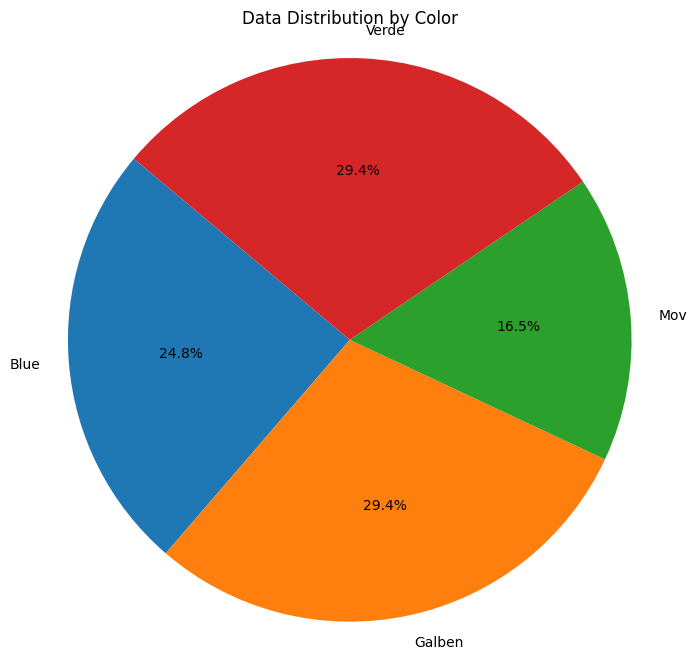

In [14]:
import matplotlib.pyplot as plt

# Calculate the number of samples for each type
sizes = [X_Blue.shape[0], X_Galben.shape[0], X_mov.shape[0], X_Verde.shape[0]]
labels = ['Blue', 'Galben', 'Mov', 'Verde']

# Create a pie chart
plt.figure(figsize=(8, 8)) 
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140)
plt.title('Data Distribution by Color')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

In [26]:
#Make a dictionary for the colors and the concatenated data
data_dict = {
    'Blue': (X_Blue, y_Blue),
    'Galben': (X_Galben, y_Galben),
    'Mov': (X_mov, y_mov),
    'Verde': (X_Verde, y_Verde),
    "All" : (X_all, y_all)
}

In [27]:
shallow_NN = shallow_nn_models(data_dict)
metrics = shallow_NN.train_model(shallow_NN.train_knn)
print(metrics)

TypeError: cpu_count() got an unexpected keyword argument 'only_physical_cores'

In [91]:
from sklearn.neural_network import MLPClassifier

def train_MLP(X_train, y_train):
    # Initialize the MLP classifier
    mlp = MLPClassifier(hidden_layer_sizes=(100,), max_iter=300, random_state=42)
    
    # Fit the classifier on the training data
    mlp.fit(X_train, y_train)
    
    # Return the trained model
    return mlp

In [29]:
metrics_MLP = shallow_NN.train_model(train_MLP)
print(metrics_MLP)

{'Blue': {'accuracy': 0.5454545454545454}, 'Galben': {'accuracy': 0.5811965811965812}, 'Mov': {'accuracy': 0.6515151515151515}, 'Verde': {'accuracy': 0.635593220338983}, 'All': {'accuracy': 0.606516290726817}}


In [99]:
from sklearn.ensemble import RandomForestClassifier


In [100]:
def train_RandomForest(X_train, y_train):
    # Initialize the Random Forest classifier
    rf = RandomForestClassifier(n_estimators=100, random_state=42)
            
            # Fit the classifier on the training data
    rf.fit(X_train, y_train)
            
            # Return the trained model
    return rf

In [42]:
metrics_RF = shallow_NN.train_model(train_RandomForest)
print(metrics_RF)

{'Blue': {'accuracy': 0.7171717171717171}, 'Galben': {'accuracy': 0.7948717948717948}, 'Mov': {'accuracy': 0.9090909090909091}, 'Verde': {'accuracy': 0.940677966101695}, 'All': {'accuracy': 0.7192982456140351}}


In [93]:
from sklearn.ensemble import GradientBoostingClassifier

def train_GradientBoosting(X_train, y_train):
    # Initialize the Gradient Boosting classifier
    gb = GradientBoostingClassifier(n_estimators=100, random_state=42)

    # Fit the classifier on the training data
    gb.fit(X_train, y_train)

    # Return the trained model
    return gb

In [21]:
metrics_GB = shallow_NN.train_model(train_GradientBoosting)
print(metrics_GB)

{'Blue': {'accuracy': 0.7676767676767676}, 'Galben': {'accuracy': 0.7863247863247863}, 'Mov': {'accuracy': 0.8939393939393939}, 'Verde': {'accuracy': 0.8898305084745762}, 'All': {'accuracy': 0.7092731829573935}}


In [30]:
from sklearn.ensemble import GradientBoostingClassifier

def train_GradientBoostingTrees(X_train, y_train):
    # Initialize the Gradient Boosting Trees classifier
    gbt = GradientBoostingClassifier(n_estimators=100, random_state=42)

    # Fit the classifier on the training data
    gbt.fit(X_train, y_train)

    # Return the trained model
    return gbt

In [23]:
metrics_GBT = shallow_NN.train_model(train_GradientBoostingTrees)
print(metrics_GBT)

{'Blue': {'accuracy': 0.7676767676767676}, 'Galben': {'accuracy': 0.7863247863247863}, 'Mov': {'accuracy': 0.8939393939393939}, 'Verde': {'accuracy': 0.8898305084745762}, 'All': {'accuracy': 0.7092731829573935}}


In [31]:
def calculate_accuracy_diff(metrics_dict):
    differences = []
    all_accuracy = metrics_dict['All']['accuracy']
    
    for key, value in metrics_dict.items():
        if key != 'All':
            diff = ( value['accuracy'] - all_accuracy) * 100
            differences.append(diff)
    
    mean_diff = np.mean(differences)
    return mean_diff

In [27]:
mean_diff = calculate_accuracy_diff(metrics)
print(mean_diff)

5.797685068425482


In [28]:
mean_diff_MLP = calculate_accuracy_diff(metrics_MLP)
print(mean_diff_MLP)

-0.3076416100501713


In [29]:
mean_diff_RF = calculate_accuracy_diff(metrics_RF)
print(mean_diff_RF)

12.11548511949939


In [30]:
mean_diff_GB = calculate_accuracy_diff(metrics_GB)
print(mean_diff_GB)

12.516968114648753


In [31]:
mean_diff_GBT = calculate_accuracy_diff(metrics_GBT)
print(mean_diff_GBT)

12.516968114648753


In [32]:
#Make mean of mean_diffs
mean_of_mean_diffs = np.mean([mean_diff, mean_diff_MLP, mean_diff_RF, mean_diff_GB, mean_diff_GBT])
print(mean_of_mean_diffs)

8.527892961434443


In [69]:
def test_data(yus):
    zeros = 0
    ones = 0
    for i in range(len(yus)):
        if yus[i] == 0:
            zeros += 1
        else:
            ones += 1
    print(f"Number of zeros: {zeros}")  
    print(f"Number of ones: {ones}")

In [17]:
XBLue_augmented,yBlue_augmented = increase_dataset_with_augmented_data(Blue_generator,X_Blue, y_Blue)

NameError: name 'Blue_generator' is not defined

In [71]:
XBLue_augmented.shape

(924, 16, 1000)

In [72]:
XYellow_augmented,yYellow_augmented = increase_dataset_with_augmented_data(galbel_generator,X_Galben, y_Galben)

In [73]:
print(XYellow_augmented.shape)
print(test_data(yYellow_augmented))

(934, 16, 1000)
Number of zeros: 467
Number of ones: 467
None


In [75]:
Xmov_augmented,ymov_augmented = increase_dataset_with_augmented_data(mov_generator,X_mov, y_mov)

In [76]:
print(Xmov_augmented.shape)
print(test_data(ymov_augmented))

(686, 16, 1000)
Number of zeros: 343
Number of ones: 343
None


In [77]:
XVerde_augmented,yVerde_augmented = increase_dataset_with_augmented_data(green_generator,X_Verde, y_Verde)

In [78]:
print(XVerde_augmented.shape)
print(test_data(yVerde_augmented))

(920, 16, 1000)
Number of zeros: 460
Number of ones: 460
None


In [79]:
XAll_augmented = np.concatenate((XBLue_augmented, XYellow_augmented, Xmov_augmented, XVerde_augmented), axis=0)
yAll_augmented = np.concatenate((yBlue_augmented, yYellow_augmented, ymov_augmented, yVerde_augmented), axis=0)

In [81]:
print(XAll_augmented.shape)
print(test_data(yAll_augmented))

(3464, 16, 1000)
Number of zeros: 1732
Number of ones: 1732
None


In [18]:
np.savez('Blue.npz', X=XBLue_augmented, y=yBlue_augmented)

NameError: name 'XBLue_augmented' is not defined

In [83]:
np.savez('Mov.npz', X=Xmov_augmented, y=ymov_augmented)

In [84]:
np.savez('Verde.npz', X=XVerde_augmented, y=yVerde_augmented)

In [85]:
np.savez('Yellow.npz', X=XYellow_augmented, y=yYellow_augmented)

In [86]:
np.savez('All.npz', X=XAll_augmented, y=yAll_augmented)

In [14]:
#LOad the file All.npz
data = np.load('All.npz')
XAll_augmented = data['X']
yAll_augmented = data['y']

In [15]:
data = np.load("Blue.npz")
XBLue_augmented = data['X']
yBlue_augmented = data['y']

In [16]:
data = np.load("Mov.npz")
Xmov_augmented = data['X']
ymov_augmented = data['y']

In [17]:
data = np.load("Verde.npz")
XVerde_augmented = data['X']
yVerde_augmented = data['y']

In [18]:
data = np.load("Yellow.npz")
XYellow_augmented = data['X']
yYellow_augmented = data['y']

In [19]:
#Make a dictionary for the colors and the concatenated data
data_dict_fake = {
    'Blue': (XBLue_augmented, yBlue_augmented),
    'Galben': (XYellow_augmented, yYellow_augmented),
    'Mov': (Xmov_augmented, ymov_augmented),
    'Verde': (XVerde_augmented, yVerde_augmented),
    "All" : (XAll_augmented, yAll_augmented)
}

In [187]:
Xus,yus = get_fake_data_from_generatorus(all_generator, X_all, y_all)

In [188]:
Xus.shape

(3187, 16, 1000)

In [88]:
shallow_NN_augmented = shallow_nn_models(data_dict_fake)


In [89]:
metrics = shallow_NN_augmented.train_model(shallow_NN.train_knn)
print(metrics) 

NameError: name 'shallow_NN' is not defined

In [95]:
metrics_MLP_augmented = shallow_NN_augmented.train_model(train_MLP)
print(metrics_MLP_augmented)

{'Blue': {'accuracy': 0.827027027027027}, 'Galben': {'accuracy': 0.6951871657754011}, 'Mov': {'accuracy': 0.855072463768116}, 'Verde': {'accuracy': 0.6684782608695652}, 'All': {'accuracy': 0.7561327561327561}}


In [39]:
print(metrics_MLP_augmented)


{'Blue': {'accuracy': 0.8354430379746836}, 'Galben': {'accuracy': 0.6951871657754011}, 'Mov': {'accuracy': 0.819047619047619}, 'Verde': {'accuracy': 0.6808510638297872}, 'All': {'accuracy': 0.7366771159874608}}


In [44]:
print(metrics_RF)

{'Blue': {'accuracy': 0.7171717171717171}, 'Galben': {'accuracy': 0.7948717948717948}, 'Mov': {'accuracy': 0.9090909090909091}, 'Verde': {'accuracy': 0.940677966101695}, 'All': {'accuracy': 0.7192982456140351}}


In [101]:
metrics_RF_augmented = shallow_NN_augmented.train_model(train_RandomForest)
print(metrics_RF_augmented)

{'Blue': {'accuracy': 0.8432432432432433}, 'Galben': {'accuracy': 0.8502673796791443}, 'Mov': {'accuracy': 0.8623188405797102}, 'Verde': {'accuracy': 0.8206521739130435}, 'All': {'accuracy': 0.7546897546897547}}


In [20]:
import torch
fs= 250                  #sampling frequency
channel= 16              #number of electrode
num_input= 1             #number of channel picture (for EEG signal is always : 1)
num_class= 1             #number of classes 
signal_length = 1000      #number of sample in each tarial

F1= 8                    #number of temporal filters
D= 3                     #depth multiplier (number of spatial filters)
F2= D*F1                 #number of pointwise filters

In [21]:
device= 'cuda'
kernel_size_1= (1,round(fs/2)) 
kernel_size_2= (channel, 1)
kernel_size_3= (1, round(fs/8))
kernel_size_4= (1, 1)

kernel_avgpool_1= (1,4)
kernel_avgpool_2= (1,8)
dropout_rate= 0.2

ks0= int(round((kernel_size_1[0]-1)/2))
ks1= int(round((kernel_size_1[1]-1)/2))
kernel_padding_1= (ks0, ks1-1)
ks0= int(round((kernel_size_3[0]-1)/2))
ks1= int(round((kernel_size_3[1]-1)/2))
kernel_padding_3= (ks0, ks1)



In [22]:
import torch.nn as nn

class EEGNet(nn.Module): 
    def __init__(self):
        super().__init__()
        # layer 1
        self.conv2d = nn.Conv2d(num_input, F1, kernel_size_1, padding=kernel_padding_1)
        self.Batch_normalization_1 = nn.BatchNorm2d(F1)
        # layer 2
        self.Depthwise_conv2D = nn.Conv2d(F1, D*F1, kernel_size_2, groups= F1)
        self.Batch_normalization_2 = nn.BatchNorm2d(D*F1)
        self.Elu = nn.ELU()
        self.Average_pooling2D_1 = nn.AvgPool2d(kernel_avgpool_1)
        self.Dropout = nn.Dropout2d(dropout_rate)
        # layer 3
        self.Separable_conv2D_depth = nn.Conv2d(D*F1, D*F1, kernel_size_3, padding=kernel_padding_3, groups= D*F1)
        self.Separable_conv2D_point = nn.Conv2d(D*F1, F2, kernel_size_4)
        self.Batch_normalization_3 = nn.BatchNorm2d(F2)
        self.Average_pooling2D_2 = nn.AvgPool2d(kernel_avgpool_2)
        # layer 4
        self.Flatten = nn.Flatten()
        self.LSTM = nn.LSTM(input_size=F2*round(signal_length/32), hidden_size=128, batch_first=True)
        self.Dense = nn.Linear(128, num_class)
        self.Softmax = nn.Sigmoid()
        
    def forward(self, x):
        # layer 1
        y = self.Batch_normalization_1(self.conv2d(x))
        # layer 2
        y = self.Batch_normalization_2(self.Depthwise_conv2D(y))
        y = self.Elu(y)
        y = self.Dropout(self.Average_pooling2D_1(y))
        # layer 3
        y = self.Separable_conv2D_depth(y)
        y = self.Batch_normalization_3(self.Separable_conv2D_point(y))
        y = self.Elu(y)
        y = self.Dropout(self.Average_pooling2D_2(y))
        # layer 4
        y = self.Flatten(y)
        y = y.unsqueeze(1)  # Add sequence dimension for LSTM
        y, _ = self.LSTM(y)
        y = y[:, -1, :]  # Take the last output of the LSTM
        y = self.Dense(y)
        y = self.Softmax(y)
        
        return y

In [105]:
X_all_augmented, y_all_augmented =get_fake_data_from_generatorus(all_generator,X_all,y_all)

In [106]:
X_all_augmented.shape

(3187, 16, 1000)

In [107]:
#Could you squexx from X_all_augmented the shape from (16,1000) to (16000,1)
X_all_augmented = X_all_augmented.reshape(3187, 16000)

In [108]:
X_all_augmented.shape

(3187, 16000)

In [160]:
XYellow_augmented.shape

(934, 16, 1000)

In [23]:
import torch
import numpy as np
from torch.utils.data import DataLoader, TensorDataset
XVerde_augmented_reshaped = XAll_augmented.reshape(XAll_augmented.shape[0],  16000)
# Convert data to tensors
signal = torch.tensor(XVerde_augmented_reshaped)
label = torch.tensor(yAll_augmented)
print(signal.shape)
# Define batch size
train_batch_size = 64

# Define the split ratio
train_size = int(0.8 * len(signal))
test_size = len(signal) - train_size

# Split the signal and label into training and testing sets
# Shuffle the data before splitting
indices = torch.randperm(signal.size(0))
shuffled_signal = signal[indices]
shuffled_label = label[indices]

# Split the shuffled data
train_signal, test_signal = torch.split(shuffled_signal, [train_size, test_size])
train_label, test_label = torch.split(shuffled_label, [train_size, test_size])
# Create TensorDatasets for training and testing sets
train_dataset = TensorDataset(train_signal, train_label)
test_dataset = TensorDataset(test_signal, test_label)

# Create DataLoaders for training and testing sets
train_loader = DataLoader(train_dataset, batch_size=train_batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=train_batch_size, shuffle=True)

# Print the shape of the transformed signal
for data in train_loader:
    print(data[0].shape)
    break

for data in test_loader:
    print(data[0].shape)
    break

torch.Size([3464, 16000])
torch.Size([64, 16000])
torch.Size([64, 16000])


In [24]:

# Create a TensorDataset and DataLoader
dataset = TensorDataset(signal, label)
data_loader = DataLoader(dataset, batch_size=train_batch_size, shuffle=True)

# Correct print statement
print("train batch size:", train_loader.batch_size, ", num of batch:", len(train_loader))


train batch size: 64 , num of batch: 44


In [25]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [26]:
from torchmetrics import Accuracy


def train_one_epoch(model, train_loader, loss_fn, optimizer):
    model.train()
    loss_train = AverageMeter()
    acc_train = Accuracy(task='binary').to(device)
    
    for i, (inputs, targets) in enumerate(train_loader):
        inputs = inputs.to(device)
        targets = targets.to(device)
        inputs = inputs.float().to(device)
        model = model.to(device)
        #Iterate through inputs
        outputs = model(inputs)
        outputs = outputs.squeeze(1).float()
        targets = targets.float()
        loss = loss_fn(outputs, targets)
        
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), 1)
        optimizer.step()
        optimizer.zero_grad()

        loss_train.update(loss.item())
        acc_train(outputs, targets.int())
        
    return model, loss_train.avg, acc_train.compute().item()

In [27]:
from tqdm import tqdm
import torch.optim as optim
model = EEGNet()

num_epochs = 15
loss_fn = nn.BCEWithLogitsLoss().to(device)
optimizer = optim.NAdam(model.parameters(), lr=0.001)

loss_train_hist = []
acc_train_hist = []

for epoch in range(num_epochs):
    with tqdm(total=len(train_loader), desc=f'Epoch {epoch+1}/{num_epochs}', unit='batch') as pbar:
        model, loss_train, acc_train = train_one_epoch(model, train_loader, loss_fn, optimizer)
        pbar.set_postfix({'Loss': f'{loss_train:.4f}', 'Accuracy': f'{acc_train*100:.2f}%'})
        pbar.update()

    loss_train_hist.append(loss_train)
    acc_train_hist.append(acc_train)

    if (epoch % 10 == 5) or (epoch % 10 == 0):
        print(f'epoch {epoch}:')
        print(f' Loss= {loss_train:.4}, Accuracy= {int(acc_train*100)}% \n')

Epoch 1/15:   0%|          | 0/44 [00:01<?, ?batch/s]


RuntimeError: Expected 3D (unbatched) or 4D (batched) input to conv2d, but got input of size: [64, 16000]

In [38]:
def test_model(model, data_loader, loss_fn, device):
    model.eval()  # Set the model to evaluation mode
    total_loss = 0.0
    correct_predictions = 0
    total_samples = 0

    with torch.no_grad():  # Disable gradient computation
        for batch in data_loader:
            inputs, targets = batch
            inputs, targets = inputs.to(device), targets.to(device)
            inputs = inputs.float().to(device).unsqueeze(1)
            outputs = model(inputs)
            outputs = outputs.squeeze(1).float()
            print(outputs)

            targets = targets.float()
            loss = loss_fn(outputs, targets)
            total_loss += loss.item()

            # Assuming binary classification
            predicted = (outputs > 0.5).float()
            correct_predictions += (predicted == targets).sum().item()
            total_samples += targets.size(0)

    avg_loss = total_loss / len(data_loader)
    accuracy = correct_predictions / total_samples

    return avg_loss, accuracy

# Example usage:
test_loss, test_accuracy = test_model(model, test_loader, loss_fn, device)
print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy*100:.2f}%')

RuntimeError: Given groups=1, weight of size [8, 1, 1, 125], expected input[1, 64, 1, 16000] to have 1 channels, but got 64 channels instead

In [28]:
import torch
import torch.nn as nn

class ResidualBlock(nn.Module):
    def __init__(self, channels):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv1d(channels, channels, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm1d(channels)
        self.relu = nn.ReLU()
        self.conv2 = nn.Conv1d(channels, channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm1d(channels)

    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out += residual
        out = self.relu(out)
        return out

In [29]:
import torch
import torch.nn as nn

class CombinedEEGNet(nn.Module):
    def __init__(self):
        super(CombinedEEGNet, self).__init__()
        self.lstm1 = nn.LSTM(input_size=1000, hidden_size=125, batch_first=True)
        self.lstm2 = nn.LSTM(input_size=125, hidden_size=50, batch_first=True)
        self.lstm3 = nn.LSTM(input_size=50, hidden_size=75, batch_first=True)
        self.lstm4 = nn.LSTM(input_size=75, hidden_size=125, batch_first=True)
        self.lstm_activation = nn.Tanh()
        self.upsample1 = nn.ConvTranspose1d(in_channels=16, out_channels=16, kernel_size=2, stride=2)
        self.conv1 = nn.Conv1d(in_channels=16, out_channels=16, kernel_size=3, padding=1)
        self.batch_norm1 = nn.BatchNorm1d(16)
        self.relu_layer1 = nn.ReLU()
        self.resblock1 = ResidualBlock(16)
        self.upsample2 = nn.ConvTranspose1d(in_channels=16, out_channels=16, kernel_size=2, stride=2)
        self.conv2 = nn.Conv1d(in_channels=16, out_channels=16, kernel_size=3, padding=1)
        self.batch_norm2 = nn.BatchNorm1d(16)
        self.relu_layer2 = nn.ReLU()
        self.resblock2 = ResidualBlock(16)
        self.upsample3 = nn.ConvTranspose1d(in_channels=16, out_channels=16, kernel_size=2, stride=2)
        self.conv3 = nn.Conv1d(in_channels=16, out_channels=16, kernel_size=3, padding=1)
        self.batch_norm3 = nn.BatchNorm1d(16)
        self.relu_layer3 = nn.ReLU()
        self.resblock3 = ResidualBlock(16)
        self.upsample4 = nn.ConvTranspose1d(in_channels=16, out_channels=16, kernel_size=2, stride=2)
        self.conv4 = nn.Conv1d(in_channels=16, out_channels=16, kernel_size=3, padding=1)
        self.batch_norm4 = nn.BatchNorm1d(16)
        self.relu_layer4 = nn.ReLU()
        self.resblock4 = ResidualBlock(16)
        self.downsample1 = nn.Conv1d(in_channels=16, out_channels=16, kernel_size=3, stride=2, padding=1)
        self.downsample_activation = nn.ReLU()
        
        # Adding 30 more convolutional layers
        self.extra_convs = nn.ModuleList([nn.Conv1d(16, 16, kernel_size=3, padding=1) for _ in range(30)])
        self.extra_bns = nn.ModuleList([nn.BatchNorm1d(16) for _ in range(30)])
        self.extra_relus = nn.ModuleList([nn.ReLU() for _ in range(30)])
        
        self.flatten = nn.Flatten()
        self.linear = nn.Linear(16000, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = x.view(-1, 16, 1000)
        x, _ = self.lstm1(x)
        x = self.upsample1(x)
        x = self.conv1(x)
        x = self.batch_norm1(x)
        x = self.relu_layer1(x)
        x = self.resblock1(x)
        x = self.upsample2(x)
        x = self.conv2(x)
        x = self.batch_norm2(x)
        x = self.relu_layer2(x)
        x = self.resblock2(x)
        x = self.upsample3(x)
        x = self.conv3(x)
        x = self.batch_norm3(x)
        x = self.relu_layer3(x)
        x = self.resblock3(x)
        x = self.upsample4(x)
        x = self.conv4(x)
        x = self.batch_norm4(x)
        x = self.relu_layer4(x)
        x = self.resblock4(x)
        x = self.downsample1(x)
        
        # Forward pass through the additional convolutional layers
        for conv, bn, relu in zip(self.extra_convs, self.extra_bns, self.extra_relus):
            x = conv(x)
            x = bn(x)
            x = relu(x)
        
        x = self.flatten(x)
        x = self.linear(x)
        x = self.sigmoid(x)
        return x

In [45]:
from tqdm import tqdm
import torch.optim as optim
model = CombinedEEGNet()

num_epochs = 100
loss_fn = nn.BCELoss().to(device)
optimizer = optim.NAdam(model.parameters(), lr=0.001)

loss_train_hist = []
acc_train_hist = []

for epoch in range(num_epochs):
    with tqdm(total=len(train_loader), desc=f'Epoch {epoch+1}/{num_epochs}', unit='batch') as pbar:
        model, loss_train, acc_train = train_one_epoch(model, train_loader, loss_fn, optimizer)
        pbar.set_postfix({'Loss': f'{loss_train:.4f}', 'Accuracy': f'{acc_train*100:.2f}%'})
        pbar.update()

    loss_train_hist.append(loss_train)
    acc_train_hist.append(acc_train)

    if (epoch % 10 == 5) or (epoch % 10 == 0):
        print(f'epoch {epoch}:')
        print(f' Loss= {loss_train:.4}, Accuracy= {int(acc_train*100)}% \n')

Epoch 2/100:   0%|          | 0/44 [00:00<?, ?batch/s]

epoch 0:
 Loss= 0.9274, Accuracy= 49% 



Epoch 7/100:   0%|          | 0/44 [00:00<?, ?batch/s]

epoch 5:
 Loss= 0.682, Accuracy= 56% 



Epoch 12/100:   0%|          | 0/44 [00:00<?, ?batch/s]

epoch 10:
 Loss= 0.4494, Accuracy= 72% 



Epoch 17/100:   0%|          | 0/44 [00:00<?, ?batch/s]

epoch 15:
 Loss= 0.4157, Accuracy= 72% 



Epoch 22/100:   0%|          | 0/44 [00:00<?, ?batch/s]

epoch 20:
 Loss= 0.4051, Accuracy= 75% 



Epoch 27/100:   0%|          | 0/44 [00:00<?, ?batch/s]

epoch 25:
 Loss= 0.3956, Accuracy= 75% 



Epoch 32/100:   0%|          | 0/44 [00:00<?, ?batch/s]

epoch 30:
 Loss= 0.4004, Accuracy= 75% 



Epoch 37/100:   0%|          | 0/44 [00:00<?, ?batch/s]

epoch 35:
 Loss= 0.398, Accuracy= 75% 



Epoch 42/100:   0%|          | 0/44 [00:00<?, ?batch/s]

epoch 40:
 Loss= 0.3944, Accuracy= 75% 



Epoch 47/100:   0%|          | 0/44 [00:00<?, ?batch/s]

epoch 45:
 Loss= 0.3968, Accuracy= 75% 



Epoch 52/100:   0%|          | 0/44 [00:00<?, ?batch/s]

epoch 50:
 Loss= 0.3957, Accuracy= 75% 



Epoch 57/100:   0%|          | 0/44 [00:00<?, ?batch/s]

epoch 55:
 Loss= 0.3956, Accuracy= 75% 



Epoch 62/100:   0%|          | 0/44 [00:00<?, ?batch/s]

epoch 60:
 Loss= 0.3948, Accuracy= 75% 



Epoch 67/100:   0%|          | 0/44 [00:00<?, ?batch/s]

epoch 65:
 Loss= 0.3951, Accuracy= 75% 



Epoch 72/100:   0%|          | 0/44 [00:00<?, ?batch/s]

epoch 70:
 Loss= 0.3933, Accuracy= 75% 



Epoch 77/100:   0%|          | 0/44 [00:00<?, ?batch/s]

epoch 75:
 Loss= 0.3947, Accuracy= 75% 



Epoch 82/100:   0%|          | 0/44 [00:00<?, ?batch/s]

epoch 80:
 Loss= 0.3951, Accuracy= 75% 



Epoch 87/100:   0%|          | 0/44 [00:00<?, ?batch/s]

epoch 85:
 Loss= 0.3939, Accuracy= 75% 



Epoch 92/100:   0%|          | 0/44 [00:00<?, ?batch/s]

epoch 90:
 Loss= 0.3946, Accuracy= 75% 



Epoch 97/100:   0%|          | 0/44 [00:00<?, ?batch/s]

epoch 95:
 Loss= 0.3924, Accuracy= 75% 



Epoch 100/100:   2%|▏         | 1/44 [00:01<01:19,  1.85s/batch, Loss=0.3932, Accuracy=75.97%]


In [46]:
def test_model(model, data_loader, loss_fn, device):
    model.eval()  # Set the model to evaluation mode
    total_loss = 0.0
    correct_predictions = 0
    total_samples = 0

    with torch.no_grad():  # Disable gradient computation
        for batch in data_loader:
            inputs, targets = batch
            inputs, targets = inputs.to(device), targets.to(device)
            inputs = inputs.float().to(device).unsqueeze(1)
            outputs = model(inputs)
            outputs = outputs.squeeze(1).float()
            targets = targets.float()
            loss = loss_fn(outputs, targets)
            total_loss += loss.item()

            # Assuming binary classification
            predicted = (outputs > 0.5).float()
            correct_predictions += (predicted == targets).sum().item()
            total_samples += targets.size(0)

    avg_loss = total_loss / len(data_loader)
    accuracy = correct_predictions / total_samples

    return avg_loss, accuracy

# Example usage:
test_loss, test_accuracy = test_model(model, test_loader, loss_fn, device)
print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy*100:.2f}%')

Test Loss: 0.4588, Test Accuracy: 73.30%


In [47]:
model.to('cpu')

CombinedEEGNet(
  (lstm1): LSTM(1000, 125, batch_first=True)
  (lstm2): LSTM(125, 50, batch_first=True)
  (lstm3): LSTM(50, 75, batch_first=True)
  (lstm4): LSTM(75, 125, batch_first=True)
  (lstm_activation): Tanh()
  (upsample1): ConvTranspose1d(16, 16, kernel_size=(2,), stride=(2,))
  (conv1): Conv1d(16, 16, kernel_size=(3,), stride=(1,), padding=(1,))
  (batch_norm1): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu_layer1): ReLU()
  (resblock1): ResidualBlock(
    (conv1): Conv1d(16, 16, kernel_size=(3,), stride=(1,), padding=(1,))
    (bn1): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
    (conv2): Conv1d(16, 16, kernel_size=(3,), stride=(1,), padding=(1,))
    (bn2): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (upsample2): ConvTranspose1d(16, 16, kernel_size=(2,), stride=(2,))
  (conv2): Conv1d(16, 16, kernel_size=(3,), stride=(1,), padding=(1,))

In [51]:
#Save the model
torch.save(model.state_dict(), 'model.pth')

In [55]:
model_2 = CombinedEEGNet()
model_2.load_state_dict(torch.load('model.pth',weights_only=True))

<All keys matched successfully>

In [54]:
print(model_2)

CombinedEEGNet(
  (lstm1): LSTM(1000, 125, batch_first=True)
  (lstm2): LSTM(125, 50, batch_first=True)
  (lstm3): LSTM(50, 75, batch_first=True)
  (lstm4): LSTM(75, 125, batch_first=True)
  (lstm_activation): Tanh()
  (upsample1): ConvTranspose1d(16, 16, kernel_size=(2,), stride=(2,))
  (conv1): Conv1d(16, 16, kernel_size=(3,), stride=(1,), padding=(1,))
  (batch_norm1): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu_layer1): ReLU()
  (resblock1): ResidualBlock(
    (conv1): Conv1d(16, 16, kernel_size=(3,), stride=(1,), padding=(1,))
    (bn1): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
    (conv2): Conv1d(16, 16, kernel_size=(3,), stride=(1,), padding=(1,))
    (bn2): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (upsample2): ConvTranspose1d(16, 16, kernel_size=(2,), stride=(2,))
  (conv2): Conv1d(16, 16, kernel_size=(3,), stride=(1,), padding=(1,))

In [56]:
print(torch.__version__)

2.4.0+cu124
